# Movie Recommendation System

## Libraries

In [1]:
import pandas as pd
import json
import ast
import numpy as np

In [2]:
credits = pd.read_csv('.csv /credits.csv')
keywords = pd.read_csv('.csv /keywords.csv')
links_small = pd.read_csv('.csv /links_small.csv')
links = pd.read_csv('.csv /links.csv')
movies_metadata = pd.read_csv('.csv /movies_metadata.csv')
ratings_small = pd.read_csv('.csv /ratings_small.csv')
ratings = pd.read_csv('.csv /ratings.csv')

/var/folders/vs/t6hclhb524l53jbbc2n222640000gn/T/ipykernel_71434/2482702822.py:5: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  movies_metadata = pd.read_csv('.csv /movies_metadata.csv')


In [3]:
movies_raw = movies_metadata.copy()

# Keep raw vote counts and averages (numeric, no transforms)
movies_raw['vote_count_raw'] = pd.to_numeric(movies_raw['vote_count'], errors='coerce')
movies_raw['vote_average_raw'] = pd.to_numeric(movies_raw['vote_average'], errors='coerce')

# Drop missing or zero vote counts
movies_raw = movies_raw.dropna(subset=['vote_count_raw', 'vote_average_raw'])
movies_raw = movies_raw[movies_raw['vote_count_raw'] > 0]

In [4]:
# Parse JSON-like columns into structured Python objects

movies_metadata['id'] = pd.to_numeric(movies_metadata['id'], errors='coerce')

credits = credits[credits['id'].apply(lambda x: str(x).isdigit())].copy()
credits['id'] = credits['id'].astype(int)
for col in ['cast', 'crew']:
    credits[col] = credits[col].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else [])
    
# cast id/tmdbId to numeric types only after filtering non-numeric rows and quantify rows dropped    
movies_metadata.dropna(subset=['id'], inplace=True)

In [5]:
movies_metadata['genres_list'] = movies_metadata['genres'].apply(
    lambda x: [g['name'] for g in json.loads(x.replace("'", '"'))] if pd.notna(x) else []
    )
movies_metadata['genres_list']

0         [Animation, Comedy, Family]
1        [Adventure, Fantasy, Family]
2                   [Romance, Comedy]
3            [Comedy, Drama, Romance]
4                            [Comedy]
                     ...             
45461                 [Drama, Family]
45462                         [Drama]
45463       [Action, Drama, Thriller]
45464                              []
45465                              []
Name: genres_list, Length: 45463, dtype: object

In [6]:
movies_metadata.shape

(45463, 25)

In [7]:
movies_metadata.isna().sum()

adult                        0
belongs_to_collection    40972
budget                       0
genres                       0
homepage                 37684
id                           0
imdb_id                     17
original_language           11
original_title               0
overview                   954
popularity                   3
poster_path                386
production_companies         3
production_countries         3
release_date                87
revenue                      3
runtime                    260
spoken_languages             3
status                      84
tagline                  25051
title                        3
video                        3
vote_average                 3
vote_count                   3
genres_list                  0
dtype: int64

In [8]:
# Drop or Fill useless part of column
import ast
movies_metadata['genres'] = movies_metadata['genres'].fillna('[]')

In [9]:
import pandas as pd
import ast  # safer than eval for these strings

def parse_json_column(df, col):
    df[col] = df[col].apply(lambda x: [] if pd.isna(x) or x == '' else ast.literal_eval(x))
    return df

movies_metadata = parse_json_column(movies_metadata, 'genres')
movies_metadata = parse_json_column(movies_metadata, 'production_countries')
movies_metadata = parse_json_column(movies_metadata, 'spoken_languages')
movies_metadata = parse_json_column(movies_metadata, 'production_companies')

In [10]:
# Store parsed list in *_list column
movies_metadata['genres_list'] = movies_metadata['genres'].apply(lambda x: [g['name'] for g in x])

# Explode for aggregation
genres_long = movies_metadata[['id', 'genres_list']].explode('genres_list')
genres_long.groupby('genres_list').size().reset_index(name='movie_count')


,genres_list,movie_count
0,Action,6596
1,Adventure,3496
2,Animation,1935
3,Comedy,13182
4,Crime,4307
5,Documentary,3932
6,Drama,20265
7,Family,2770
8,Fantasy,2313
9,Foreign,1622


In [11]:
# Handle missing/outlier numeric values
import numpy as np
import pandas as pd

# Convert to numeric where needed
numeric_cols = ['budget', 'revenue', 'runtime', 'popularity', 'vote_count']
for col in numeric_cols:
    movies_metadata[col] = pd.to_numeric(movies_metadata[col], errors='coerce')

# Fill missing values
movies_metadata['runtime'] = movies_metadata['runtime'].fillna(movies_metadata['runtime'].median())
movies_metadata['budget'] = movies_metadata['budget'].replace(0, np.nan).fillna(movies_metadata['budget'].median())
movies_metadata['revenue'] = movies_metadata['revenue'].replace(0, np.nan).fillna(movies_metadata['revenue'].median())

# Winsorisation for extreme outliers
for col in ['budget', 'revenue', 'popularity', 'vote_count']:
    movies_metadata[col] = movies_metadata[col].clip(upper=movies_metadata[col].quantile(0.99))

# Log transform skewed columns
for col in ['budget', 'revenue', 'popularity', 'vote_count']:
    movies_metadata[col] = np.log1p(movies_metadata[col])
    

# --- Boolean fields ---
movies_metadata['adult'] = movies_metadata['adult'].astype(bool)
movies_metadata['video'] = movies_metadata['video'].fillna(False).astype(bool)

# --- IDs ---
movies_metadata['imdb_id'] = movies_metadata['imdb_id'].replace('', np.nan)

# --- Languages & text ---
movies_metadata['original_language'] = movies_metadata['original_language'].fillna('unknown')
movies_metadata['status'] = movies_metadata['status'].fillna('Unknown')
movies_metadata['title'] = movies_metadata['title'].fillna(movies_metadata['original_title'])
movies_metadata['tagline'] = movies_metadata['tagline'].fillna('')
movies_metadata['overview'] = movies_metadata['overview'].fillna('No overview available')

# --- Dates ---
movies_metadata['release_date'] = pd.to_datetime(movies_metadata['release_date'], errors='coerce')

/var/folders/vs/t6hclhb524l53jbbc2n222640000gn/T/ipykernel_71434/2179892545.py:26: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  movies_metadata['video'] = movies_metadata['video'].fillna(False).astype(bool)


In [12]:
import pandas as pd
import numpy as np
import ast

# Helper to parse JSON-like columns safely
def parse_json_safe(x):
    if isinstance(x, list):
        return x
    if isinstance(x, dict):
        return [x]
    if pd.isna(x) or str(x).strip() in ('', '{}', '[]'):
        return []
    try:
        val = ast.literal_eval(x)
        if isinstance(val, dict):
            return [val]
        if isinstance(val, list):
            return val
        return []
    except Exception:
        return []

# Columns to parse JSON from strings
json_columns = [
    'belongs_to_collection',
    'genres',
    'production_companies',
    'production_countries',
    'spoken_languages'
]

for col in json_columns:
    if col in movies_metadata.columns:
        movies_metadata[col] = movies_metadata[col].apply(parse_json_safe)

# Clean imdb_id: strip, replace empty and 'nan' strings with np.nan
movies_metadata['imdb_id'] = movies_metadata['imdb_id'].astype(str).str.strip()
movies_metadata.loc[movies_metadata['imdb_id'].str.lower().isin(['', 'nan']), 'imdb_id'] = np.nan


# Fill missing poster_path and tagline with empty string
movies_metadata['poster_path'] = movies_metadata['poster_path'].fillna('')
movies_metadata['tagline'] = movies_metadata['tagline'].fillna('')

# Parse release_date, keep NaT for missing
movies_metadata['release_date'] = pd.to_datetime(movies_metadata['release_date'], errors='coerce')

# Convert boolean columns
movies_metadata['adult'] = movies_metadata['adult'].astype(bool)
movies_metadata['video'] = movies_metadata['video'].astype(bool)

# Numeric columns convert & fill if any missing (minimal missing expected)
numeric_cols = ['budget', 'popularity', 'revenue', 'runtime', 'vote_average', 'vote_count']

for col in numeric_cols:
    movies_metadata[col] = pd.to_numeric(movies_metadata[col], errors='coerce')
    movies_metadata[col] = movies_metadata[col].fillna(movies_metadata[col].median())

# Winsorize to cap extreme outliers on some numeric cols. (Handle outliers)
for col in ['budget', 'popularity', 'revenue', 'runtime', 'vote_count']:
    upper = movies_metadata[col].quantile(0.99)
    movies_metadata[col] = movies_metadata[col].clip(upper=upper)

# Log transform skewed numeric columns (except vote_average) (Handle outliers)
for col in ['budget', 'popularity', 'revenue', 'vote_count']:
    movies_metadata[col] = np.log1p(movies_metadata[col])

# Fill missing titles (if any) with original_title
movies_metadata['title'] = movies_metadata['title'].fillna(movies_metadata['original_title'])

# Handle JSON columns
movies_metadata['homepage'] = movies_metadata['homepage'].apply(parse_json_safe)

In [13]:
movies_metadata['release_date'] = pd.to_datetime(movies_metadata['release_date'], errors='coerce')
movies_metadata = movies_metadata.dropna(subset=['imdb_id'])

In [14]:
movies_metadata.isna().sum()

adult                     0
belongs_to_collection     0
budget                    0
genres                    0
homepage                  0
id                        0
imdb_id                   0
original_language         0
original_title            0
overview                  0
popularity                0
poster_path               0
production_companies      0
production_countries      0
release_date             84
revenue                   0
runtime                   0
spoken_languages          0
status                    0
tagline                   0
title                     0
video                     0
vote_average              0
vote_count                0
genres_list               0
dtype: int64

# Task1

##  Distribution of Ratings

Total ratings: 26024289
count    2.602429e+07
mean     3.528090e+00
std      1.065443e+00
min      5.000000e-01
25%      3.000000e+00
50%      3.500000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64


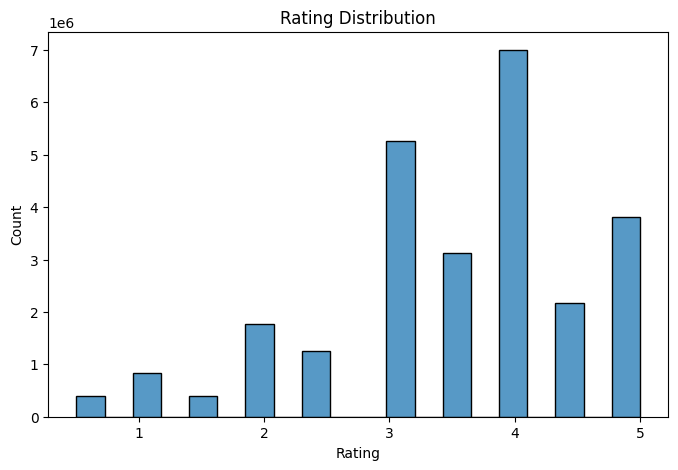

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Example: ratings column assumed to be 'rating'
print(f"Total ratings: {len(ratings)}")
print(ratings['rating'].describe())

plt.figure(figsize=(8,5))
sns.histplot(ratings['rating'], bins=20, kde=False)
plt.title("Rating Distribution")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()


##  Long-Tail of Users and Movies

Users: 270896, mean ratings per user: 96.07


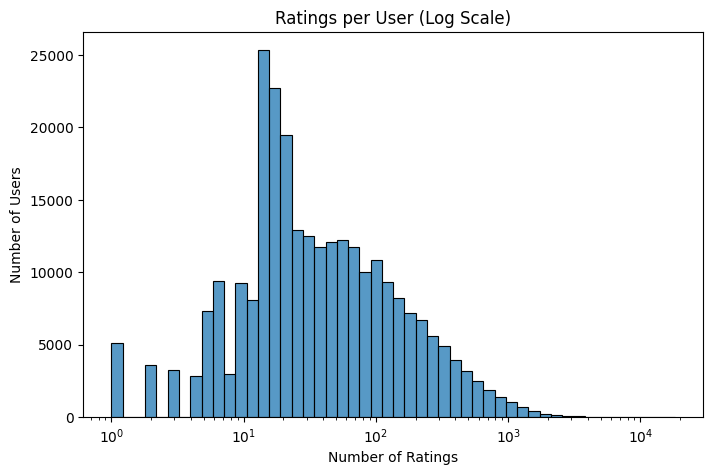

Movies: 45115, mean ratings per movie: 576.84


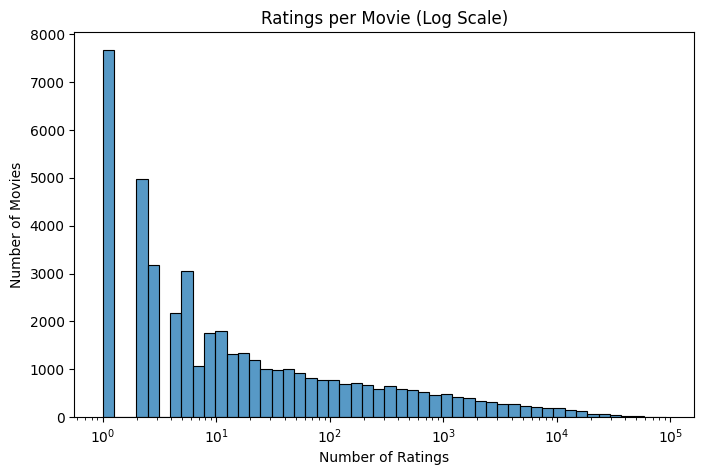

In [16]:
# Ratings per user
user_counts = ratings.groupby('userId').size()
print(f"Users: {user_counts.count()}, mean ratings per user: {user_counts.mean():.2f}")

plt.figure(figsize=(8,5))
sns.histplot(user_counts, bins=50, log_scale=(True, False))
plt.title("Ratings per User (Log Scale)")
plt.xlabel("Number of Ratings")
plt.ylabel("Number of Users")
plt.show()

# Ratings per movie
movie_counts = ratings.groupby('movieId').size()
print(f"Movies: {movie_counts.count()}, mean ratings per movie: {movie_counts.mean():.2f}")

plt.figure(figsize=(8,5))
sns.histplot(movie_counts, bins=50, log_scale=(True, False))
plt.title("Ratings per Movie (Log Scale)")
plt.xlabel("Number of Ratings")
plt.ylabel("Number of Movies")
plt.show()

## Sparsity

Sparsity of user-movie ratings matrix: 0.9979


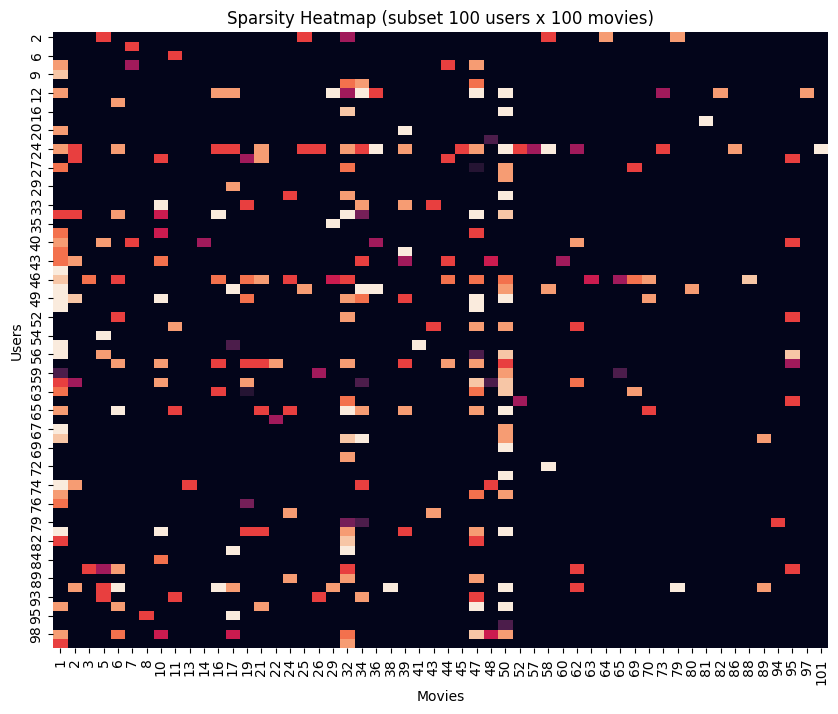

In [17]:
import numpy as np

num_users = ratings['userId'].nunique()
num_movies = ratings['movieId'].nunique()
num_possible = num_users * num_movies
num_actual = len(ratings)
sparsity = 1 - (num_actual / num_possible)
print(f"Sparsity of user-movie ratings matrix: {sparsity:.4f}")

# Optional heatmap on subset (e.g., first 100 users & 100 movies)
subset = ratings[(ratings['userId'].isin(user_counts.index[:100])) &
                    (ratings['movieId'].isin(movie_counts.index[:100]))]

pivot = subset.pivot(index='userId', columns='movieId', values='rating').fillna(0)
plt.figure(figsize=(10,8))
sns.heatmap(pivot, cbar=False)
plt.title("Sparsity Heatmap (subset 100 users x 100 movies)")
plt.xlabel("Movies")
plt.ylabel("Users")
plt.show()

##  Temporal Dynamics

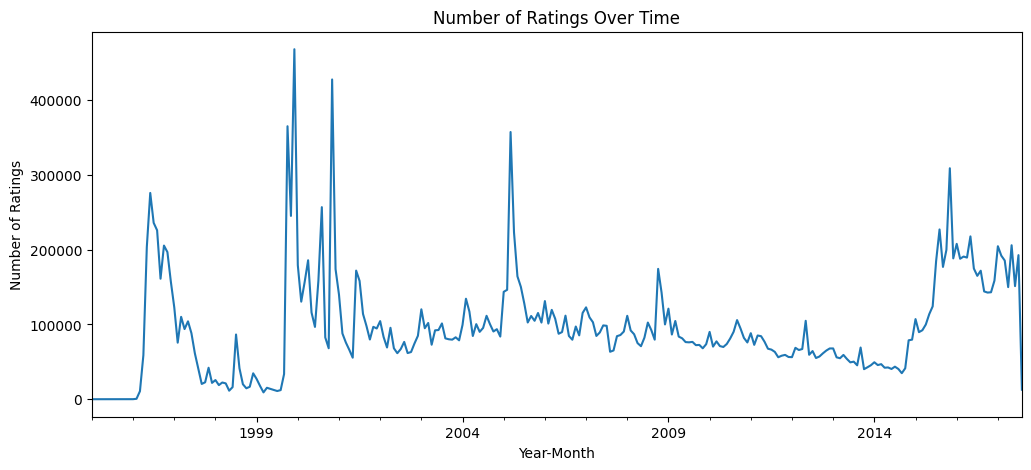

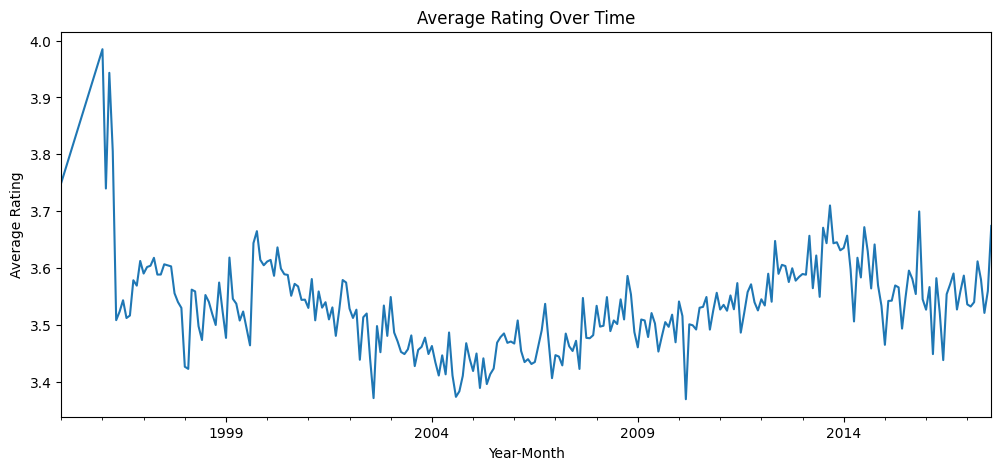

In [18]:
ratings['datetime'] = pd.to_datetime(ratings['timestamp'], unit='s')  # or appropriate unit

ratings['year_month'] = ratings['datetime'].dt.to_period('M')
time_counts = ratings.groupby('year_month').size()

plt.figure(figsize=(12,5))
time_counts.plot()
plt.title("Number of Ratings Over Time")
plt.xlabel("Year-Month")
plt.ylabel("Number of Ratings")
plt.show()

# Average rating over time
avg_rating_time = ratings.groupby('year_month')['rating'].mean()

plt.figure(figsize=(12,5))
avg_rating_time.plot()
plt.title("Average Rating Over Time")
plt.xlabel("Year-Month")
plt.ylabel("Average Rating")
plt.show()


##  Coverage Across Genres, Languages, Countries

In [19]:
import matplotlib.pyplot as plt jjkkkjj
import seaborn as sns

print(f"Ratings before join: {len(ratings)}")
print(f"Movies before join: {len(movies_metadata)}")

# Merge ratings with movies_metadata on movieId (ratings) and id (movies_metadata)
merged_df = ratings.merge(
    movies_metadata[['id', 'genres', 'original_language', 'production_countries']],
    left_on='movieId',
    right_on='id',
    how='left'
)

print(f"Ratings after join: {len(merged_df)}")

# Handle genres column:
# genres may be list of dicts like [{'id':..., 'name':...}, ...]
def extract_genre_names(genres):
    if isinstance(genres, list):
        # Extract 'name' from each dict if possible
        return [g['name'] if isinstance(g, dict) and 'name' in g else str(g) for g in genres]
    elif isinstance(genres, str):
        # If string, split by comma (if applicable)
        return genres.split(',')
    else:
        return []

merged_df['genres_list'] = merged_df['genres'].apply(extract_genre_names)

# Explode genres for counting
genres_exploded = merged_df.explode('genres_list')

# Count genres occurrences
genre_counts = genres_exploded['genres_list'].value_counts()

print("Top genres by rating counts:")
print(genre_counts.head(10))

# Plot top 10 genres
plt.figure(figsize=(10,6))
sns.barplot(x=genre_counts.head(10).values, y=genre_counts.head(10).index)
plt.title("Top 10 Genres by Number of Ratings")
plt.xlabel("Number of Ratings")
plt.ylabel("Genre")
plt.show()

# Language distribution
language_counts = merged_df['original_language'].value_counts()
print("Top languages by number of ratings:")
print(language_counts.head(10))

# Handle production_countries column:
# production_countries may be list of dicts like [{'iso_3166_1':..., 'name':...}, ...]
def extract_country_names(countries):
    if isinstance(countries, list):
        return [c['name'] if isinstance(c, dict) and 'name' in c else str(c) for c in countries]
    elif isinstance(countries, str):
        return countries.split(',')
    else:
        return []

merged_df['countries_list'] = merged_df['production_countries'].apply(extract_country_names)

# Explode countries for counting
countries_exploded = merged_df.explode('countries_list')

country_counts = countries_exploded['countries_list'].value_counts()

print("Top countries by number of ratings:")
print(country_counts.head(10))


SyntaxError: invalid syntax (1146903916.py, line 1)

## Document row counts before and after join/filter

In [ ]:
print(f"Ratings rows before filtering: {len(ratings)}")
filtered_df = merged_df[merged_df['genres'].notnull()]
print(f"Rows after filtering for non-null genres: {len(filtered_df)}")

## Task2

In [20]:
# Assuming you saved your original raw dataframe somewhere or reload it

# Convert to numeric safely
movies_raw['vote_count'] = pd.to_numeric(movies_raw['vote_count'], errors='coerce')
movies_raw['vote_average'] = pd.to_numeric(movies_raw['vote_average'], errors='coerce')

# Drop rows with missing or zero vote counts if you want
movies_raw = movies_raw.dropna(subset=['vote_count', 'vote_average'])
movies_raw = movies_raw[movies_raw['vote_count'] > 0]

# Calculate C and m
C = movies_raw['vote_average'].mean()
m = movies_raw['vote_count'].quantile(0.80)

print(f"Global mean rating C: {C:.2f}")
print(f"Minimum votes threshold m (80th percentile): {m:.0f}")

qualified = movies_raw[movies_raw['vote_count'] >= m].copy()

v = qualified['vote_count']
R = qualified['vote_average']

qualified['weighted_rating'] = (v / (v + m)) * R + (m / (v + m)) * C

top_movies = qualified.sort_values('weighted_rating', ascending=False).head(20)

print(top_movies[['original_title', 'vote_count', 'vote_average', 'weighted_rating']])


Global mean rating C: 6.00
Minimum votes threshold m (80th percentile): 56
                        original_title  vote_count  vote_average  \
10309      Dilwale Dulhania Le Jayenge       661.0           9.1   
314           The Shawshank Redemption      8358.0           8.5   
834                      The Godfather      6024.0           8.5   
40251                            君の名は。      1030.0           8.5   
12481                  The Dark Knight     12269.0           8.3   
2843                        Fight Club      9678.0           8.3   
292                       Pulp Fiction      8670.0           8.3   
522                   Schindler's List      4436.0           8.3   
23673                         Whiplash      4376.0           8.3   
5481                          千と千尋の神隠し      3968.0           8.3   
2211                   La vita è bella      3643.0           8.3   
1178            The Godfather: Part II      3418.0           8.3   
1152   One Flew Over the Cuckoo's Nest   

In [21]:
movies_metadata['vote_count'].describe()

count    45446.000000
mean         1.178330
std          0.500777
min          0.000000
25%          0.869742
50%          1.223156
75%          1.516302
max          2.162064
Name: vote_count, dtype: float64

## Task 3

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import hstack, csr_matrix
import ast  # for safely parsing strings to lists if needed

# 1. Combine text fields (overview + tagline) for TF-IDF
movies_metadata['text'] = movies_metadata['overview'].fillna('') + ' ' + movies_metadata['tagline'].fillna('')

tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(movies_metadata['text'])

# 2. Multi-hot encoding of genres
mlb_genres = MultiLabelBinarizer()
genres_encoded = mlb_genres.fit_transform(movies_metadata['genres_list'])

# 3. Prepare keywords: merge and parse
keywords['id'] = keywords['id'].astype(str)
movies_metadata['id'] = movies_metadata['id'].astype(str)

# Drop old keywords columns if any
movies_metadata = movies_metadata.drop(columns=['keywords', 'keywords_x', 'keywords_y'], errors='ignore')

# Rename keywords column before merging to avoid conflicts
keywords = keywords.rename(columns={'keywords': 'keywords_kw'})

movies_metadata = movies_metadata.merge(keywords, on='id', how='left')
movies_metadata['keywords'] = movies_metadata['keywords_kw'].fillna('[]')
movies_metadata = movies_metadata.drop(columns=['keywords_kw'])

# Function to safely parse keywords column
def parse_keywords(x):
    if isinstance(x, list):
        return x
    try:
        return ast.literal_eval(x)
    except (ValueError, SyntaxError):
        return []

movies_metadata['keywords'] = movies_metadata['keywords'].apply(parse_keywords)

mlb_keywords = MultiLabelBinarizer()
keywords_encoded = mlb_keywords.fit_transform(movies_metadata['keywords'])

# 4. Multi-hot encoding for cast
if 'top_cast_list' in movies_metadata.columns:
    movies_metadata['top_cast_list'] = movies_metadata['top_cast_list'].fillna('[]').apply(parse_keywords)
    mlb_cast = MultiLabelBinarizer()
    cast_encoded = mlb_cast.fit_transform(movies_metadata['top_cast_list'])
else:
    cast_encoded = csr_matrix((len(movies_metadata), 0))

# 5. Multi-hot encoding for crew
if 'top_crew_list' in movies_metadata.columns:
    movies_metadata['top_crew_list'] = movies_metadata['top_crew_list'].fillna('[]').apply(parse_keywords)
    mlb_crew = MultiLabelBinarizer()
    crew_encoded = mlb_crew.fit_transform(movies_metadata['top_crew_list'])
else:
    crew_encoded = csr_matrix((len(movies_metadata), 0))

# 6. Concatenate all features into one sparse matrix
item_vectors = hstack([tfidf_matrix, genres_encoded, keywords_encoded, cast_encoded, crew_encoded])

print("Item vectors shape before SVD:", item_vectors.shape)

# 7. Optional: Dimensionality reduction with TruncatedSVD
svd = TruncatedSVD(n_components=200, random_state=42)
item_vectors_reduced = svd.fit_transform(item_vectors)

print("Item vectors shape after SVD:", item_vectors_reduced.shape)


In [22]:
import numpy as np

movieId_to_idx = {mid: idx for idx, mid in enumerate(movies_metadata['id'])}
global_mean_rating = ratings['rating'].mean()
global_popularity_vector = np.mean(item_vectors_reduced, axis=0)

def build_user_profile(user_ratings):
    indices = [movieId_to_idx[m] for m in user_ratings['movieId'] if m in movieId_to_idx]
    ratings_values = user_ratings.loc[user_ratings['movieId'].isin(movieId_to_idx), 'rating'].values
    
    if len(indices) == 0:
        # Cold start: return global defaults
        return global_popularity_vector, global_mean_rating
    
    vectors = item_vectors_reduced[indices]
    mean_rating = ratings_values.mean()
    weights = ratings_values - mean_rating
    
    # Weighted average; add small epsilon to denominator to avoid division by zero if needed
    if np.all(weights == 0):
        user_profile = vectors.mean(axis=0)
    else:
        user_profile = np.average(vectors, axis=0, weights=weights)
        
    return user_profile, mean_rating

# Example usage:
user_ratings = ratings[ratings['userId'] == 123]
profile, user_mean = build_user_profile(user_ratings)

print(profile, user_mean)


NameError: name 'item_vectors_reduced' is not defined

## Task4

In [23]:
import pandas as pd
import numpy as np
import scipy.sparse as sps
from sklearn.metrics import mean_squared_error
from surprise import Dataset, Reader, KNNBasic, accuracy
from surprise.model_selection import train_test_split

# -- Data filtering (keep users & movies with >= min ratings) --
def filter_ratings(ratings, min_user=5, min_movie=5):
    user_counts = ratings['userId'].value_counts()
    movie_counts = ratings['movieId'].value_counts()
    filtered = ratings[
        ratings['userId'].isin(user_counts[user_counts >= min_user].index) &
        ratings['movieId'].isin(movie_counts[movie_counts >= min_movie].index)
    ].copy()
    return filtered

# -- Build sparse rating matrix and baseline biases --
def build_rating_matrix_and_baselines(ratings):
    user_ids = ratings['userId'].unique()
    movie_ids = ratings['movieId'].unique()
    uid_to_idx = {u:i for i,u in enumerate(user_ids)}
    mid_to_idx = {m:i for i,m in enumerate(movie_ids)}
    
    n_users, n_movies = len(user_ids), len(movie_ids)
    
    rows = ratings['userId'].map(uid_to_idx).to_numpy()
    cols = ratings['movieId'].map(mid_to_idx).to_numpy()
    data = ratings['rating'].to_numpy()
    
    R = sps.csr_matrix((data, (rows, cols)), shape=(n_users, n_movies))
    
    mu = data.mean()
    
    # User biases
    user_sum = np.zeros(n_users)
    user_count = np.zeros(n_users)
    for r, u_idx in zip(data, rows):
        user_sum[u_idx] += r
        user_count[u_idx] += 1
    bu = np.zeros(n_users)
    bu[user_count > 0] = user_sum[user_count > 0] / user_count[user_count > 0] - mu
    
    # Movie biases
    movie_sum = np.zeros(n_movies)
    movie_count = np.zeros(n_movies)
    for r, m_idx in zip(data, cols):
        movie_sum[m_idx] += r
        movie_count[m_idx] += 1
    bi = np.zeros(n_movies)
    bi[movie_count > 0] = movie_sum[movie_count > 0] / movie_count[movie_count > 0] - mu
    
    return R, mu, bu, bi, uid_to_idx, mid_to_idx

# -- Precompute normalized item columns for cosine similarity --
def precompute_item_norms(R):
    R_csc = R.tocsc()
    item_norms = np.sqrt(R_csc.power(2).sum(axis=0)).A1
    nonzero = item_norms > 0
    D_inv = sps.diags(1.0 / (item_norms[nonzero]))
    R_col = R_csc[:, nonzero]
    R_col_normed = R_col @ D_inv
    return R_csc, R_col_normed, nonzero

# -- Item neighbors for item-item CF --
def item_neighbors(i_idx, R_csc, R_col_normed, nonzero, topk=50):
    vi = R_csc[:, i_idx].toarray().ravel()
    norm_vi = np.linalg.norm(vi)
    if norm_vi < 1e-9:
        return np.array([]), np.array([])
    sims = R_col_normed.T.dot(vi / norm_vi)
    sims = np.asarray(sims).ravel()
    
    # Map back to full index space including zero-norm items
    full_sims = np.zeros(R_csc.shape[1])
    full_sims[nonzero] = sims
    
    topk_idx = np.argpartition(-full_sims, range(min(topk, len(full_sims))))[:topk]
    topk_idx = topk_idx[np.argsort(-full_sims[topk_idx])]
    return topk_idx, full_sims[topk_idx]

# -- Predict with item-item CF --
def predict_item_item(u_idx, i_idx, R, mu, bu, bi, R_csc, R_col_normed, nonzero, k=50):
    baseline = mu + bu[u_idx] + bi[i_idx]
    u_row = R[u_idx, :].toarray().ravel()
    rated_idx = np.where(u_row > 0)[0]
    if len(rated_idx) == 0:
        return baseline
    neigh_idx, sims = item_neighbors(i_idx, R_csc, R_col_normed, nonzero, topk=k)
    common_mask = np.isin(neigh_idx, rated_idx)
    neigh_idx = neigh_idx[common_mask]
    sims = sims[common_mask]
    if len(neigh_idx) == 0:
        return baseline
    ruj = u_row[neigh_idx]
    denom = np.sum(np.abs(sims)) + 1e-9
    numer = np.sum(sims * (ruj - (mu + bu[u_idx] + bi[neigh_idx])))
    return baseline + numer / denom

# -- Convert Surprise predictions to DataFrame --
def surprise_preds_to_df(predictions):
    return pd.DataFrame(
        [(uid, iid, true_r, est) for uid, iid, true_r, est, _ in predictions],
        columns=['userId', 'movieId', 'rating', 'est']
    )

# -- Vectorized evaluation for any predict_fn with fallback --
def evaluate_preds_fast(test_df, uid_to_idx, mid_to_idx, predict_fn, fallback_pred):
    valid_mask = test_df['userId'].isin(uid_to_idx) & test_df['movieId'].isin(mid_to_idx)
    preds = np.full(len(test_df), fallback_pred, dtype=float)
    
    valid_users = test_df.loc[valid_mask, 'userId'].map(uid_to_idx)
    valid_items = test_df.loc[valid_mask, 'movieId'].map(mid_to_idx)
    preds[valid_mask] = [
        predict_fn(u, i) for u, i in zip(valid_users, valid_items)
    ]
    
    rmse = np.sqrt(mean_squared_error(test_df['rating'], preds))
    return rmse

# -- Matrix Factorization with SGD and early stopping support --
def train_mf_SGD(train_df, val_df=None, n_factors=50, lr=0.005, reg=0.02, n_epochs=20, early_stopping=True, patience=3, verbose=True):
    users = train_df['userId'].unique()
    items = train_df['movieId'].unique()
    u2i = {u:idx for idx,u in enumerate(users)}
    i2j = {i:idx for idx,i in enumerate(items)}
    nU, nI = len(users), len(items)
    
    mu = train_df['rating'].mean()
    bu = np.zeros(nU)
    bi = np.zeros(nI)
    P = 0.1 * np.random.randn(nU, n_factors)
    Q = 0.1 * np.random.randn(nI, n_factors)
    
    rows = [(u2i[r['userId']], i2j[r['movieId']], r['rating']) for _, r in train_df.iterrows()]
    
    best_val_rmse = np.inf
    patience_counter = 0
    
    for epoch in range(n_epochs):
        np.random.shuffle(rows)
        sse = 0.0
        for u_idx, i_idx, r in rows:
            pred = mu + bu[u_idx] + bi[i_idx] + P[u_idx].dot(Q[i_idx])
            err = r - pred
            sse += err**2
            
            # Update biases
            bu[u_idx] += lr * (err - reg * bu[u_idx])
            bi[i_idx] += lr * (err - reg * bi[i_idx])
            
            # Update latent factors
            Pu = P[u_idx].copy()
            Qi = Q[i_idx].copy()
            P[u_idx] += lr * (err * Qi - reg * Pu)
            Q[i_idx] += lr * (err * Pu - reg * Qi)
        
        train_rmse = np.sqrt(sse / len(rows))
        
        if val_df is not None:
            val_preds = []
            for _, row in val_df.iterrows():
                u = row['userId']
                i = row['movieId']
                if u in u2i and i in i2j:
                    u_idx = u2i[u]
                    i_idx = i2j[i]
                    val_preds.append(mu + bu[u_idx] + bi[i_idx] + P[u_idx].dot(Q[i_idx]))
                else:
                    val_preds.append(mu)
            val_rmse = np.sqrt(mean_squared_error(val_df['rating'], val_preds))
            if verbose:
                print(f"Epoch {epoch+1}/{n_epochs} train RMSE={train_rmse:.4f} val RMSE={val_rmse:.4f}")
            
            if early_stopping:
                if val_rmse < best_val_rmse:
                    best_val_rmse = val_rmse
                    patience_counter = 0
                else:
                    patience_counter += 1
                    if patience_counter >= patience:
                        print("Early stopping triggered")
                        break
        else:
            if verbose:
                print(f"Epoch {epoch+1}/{n_epochs} train RMSE={train_rmse:.4f}")
    
    model = dict(mu=mu, bu=bu, bi=bi, P=P, Q=Q, u2i=u2i, i2j=i2j)
    return model

def predict_mf(model, u, i):
    u2i, i2j = model['u2i'], model['i2j']
    mu, bu, bi, P, Q = model['mu'], model['bu'], model['bi'], model['P'], model['Q']
    if u in u2i and i in i2j:
        u_idx = u2i[u]
        i_idx = i2j[i]
        return mu + bu[u_idx] + bi[i_idx] + P[u_idx].dot(Q[i_idx])
    else:
        return mu

# ============================
# Example usage:
# ============================

# Step 1: Filter ratings
ratings_filtered = filter_ratings(ratings, min_user=5, min_movie=5)

# Step 2: Build matrix & baseline
R, mu, bu, bi, uid_to_idx, mid_to_idx = build_rating_matrix_and_baselines(ratings_filtered)

# Step 3: Precompute normalized columns for item-item similarity
R_csc, R_col_normed, nonzero = precompute_item_norms(R)

# Step 4: Surprise kNN baseline example
sampled_ratings = ratings.sample(n=100000, random_state=42)
reader = Reader(rating_scale=(sampled_ratings['rating'].min(), sampled_ratings['rating'].max()))
data = Dataset.load_from_df(sampled_ratings[['userId', 'movieId', 'rating']], reader)
train_surprise, test_surprise = train_test_split(data, test_size=0.2, random_state=42)
sim_options = {'name': 'cosine', 'user_based': False}
algo = KNNBasic(k=20, sim_options=sim_options, verbose=True)
algo.fit(train_surprise)
predictions = algo.test(test_surprise)
print("Surprise kNN RMSE:", accuracy.rmse(predictions))

# Step 5: Evaluate your own item-item kNN on Surprise test set
test_df = surprise_preds_to_df(predictions)
rmse_custom = evaluate_preds_fast(test_df, uid_to_idx, mid_to_idx,
                                 lambda u, i: predict_item_item(u, i, R, mu, bu, bi, R_csc, R_col_normed, nonzero, k=20),
                                 mu)
print("Custom item-item kNN RMSE:", rmse_custom)

# Step 6: Train MF model with early stopping on a sample split
train_df = ratings_filtered.sample(frac=0.8, random_state=42)
val_df = ratings_filtered.drop(train_df.index)
mf_model = train_mf_SGD(train_df, val_df, n_factors=50, lr=0.005, reg=0.02, n_epochs=20, verbose=True)

# Step 7: Evaluate MF on val set
val_preds = [predict_mf(mf_model, u, i) for u, i in zip(val_df['userId'], val_df['movieId'])]
val_rmse = np.sqrt(mean_squared_error(val_df['rating'], val_preds))
print(f"MF validation RMSE: {val_rmse:.4f}")


KeyboardInterrupt: 

In [24]:
# Document rows before/after filters:
# initial counts
print("Ratings rows (raw):", len(ratings))

# e.g., filter to users with >= 5 ratings and movies with >= 5 ratings
min_user_ratings = 5
min_movie_ratings = 5

user_counts = ratings['userId'].value_counts()
movie_counts = ratings['movieId'].value_counts()

ratings_filtered = ratings[
    ratings['userId'].isin(user_counts[user_counts >= min_user_ratings].index) &
    ratings['movieId'].isin(movie_counts[movie_counts >= min_movie_ratings].index)
].copy()

print("Ratings rows after filtering:", len(ratings_filtered))
print("Unique users:", ratings_filtered['userId'].nunique())
print("Unique movies:", ratings_filtered['movieId'].nunique())


Ratings rows (raw): 26024289
Ratings rows after filtering: 25955041
Unique users: 256107
Unique movies: 27127


take pictures formula

## Task5

In [25]:
import pandas as pd
import numpy as np
from surprise import Dataset, Reader, KNNBasic, SVD, accuracy
from surprise.model_selection import train_test_split

# --- 0. Load and sample ratings data ---
# Assume ratings is a DataFrame with columns: userId, movieId, rating
# ratings = pd.read_csv('ratings.csv')  # Example
ratings_sample = ratings.sample(50000, random_state=42)  # smaller subset for speed

reader = Reader(rating_scale=(ratings_sample['rating'].min(), ratings_sample['rating'].max()))
data = Dataset.load_from_df(ratings_sample[['userId', 'movieId', 'rating']], reader)

# --- 1. Train/Test split ---
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# --- 2. Item–Item kNN baseline ---
sim_options = {'name': 'cosine', 'user_based': False}  # item-item
knn_algo = KNNBasic(k=50, sim_options=sim_options, verbose=False)
knn_algo.fit(trainset)
knn_preds = knn_algo.test(testset)
print("Item-Item kNN RMSE:", accuracy.rmse(knn_preds))

# --- 3. Matrix Factorisation (SVD) baseline ---
svd_algo = SVD(n_factors=50, lr_all=0.005, reg_all=0.02, n_epochs=20)
svd_algo.fit(trainset)
svd_preds = svd_algo.test(testset)
print("SVD MF RMSE:", accuracy.rmse(svd_preds))

# --- 4. Hybrid blending ---
# Convert predictions to dicts for fast lookup
knn_dict = {(p.uid, p.iid): p.est for p in knn_preds}
svd_dict = {(p.uid, p.iid): p.est for p in svd_preds}

# def blend_predictions(testset, alpha=0.5):
#     blended = []
#     for uid, iid, true_r in [(p.uid, p.iid, p.r_ui) for p in svd_preds]:
#         cf_score = svd_dict.get((uid, iid), np.mean(ratings_sample['rating']))
#         cb_score = knn_dict.get((uid, iid), np.mean(ratings_sample['rating']))
#         hybrid_est = alpha * cf_score + (1 - alpha) * cb_score
#         blended.append((true_r, hybrid_est))
#     return blended

def blend_predictions(testset, alpha=0.5):
    blended = []
    for uid, iid, true_r in testset:
        cf_score = svd_dict.get((uid, iid), np.mean(ratings_sample['rating']))
        cb_score = knn_dict.get((uid, iid), np.mean(ratings_sample['rating']))
        hybrid_est = alpha * cf_score + (1 - alpha) * cb_score
        blended.append((true_r, hybrid_est))
    return blended


# --- 5. Tune alpha manually ---
best_rmse = float('inf')
best_alpha = None
for alpha in np.linspace(0, 1, 11):  # 0.0, 0.1, ..., 1.0
    blended = blend_predictions(testset, alpha=alpha)
    y_true, y_pred = zip(*blended)
    rmse = np.sqrt(np.mean((np.array(y_true) - np.array(y_pred))**2))
    if rmse < best_rmse:
        best_rmse = rmse
        best_alpha = alpha
    print(f"alpha={alpha:.1f}, RMSE={rmse:.4f}")

print(f"\nBest alpha: {best_alpha:.2f}, RMSE={best_rmse:.4f}")


RMSE: 1.0722
Item-Item kNN RMSE: 1.0722129415918276
RMSE: 1.0042
SVD MF RMSE: 1.0041714024256736
alpha=0.0, RMSE=1.0722
alpha=0.1, RMSE=1.0604
alpha=0.2, RMSE=1.0497
alpha=0.3, RMSE=1.0400
alpha=0.4, RMSE=1.0314
alpha=0.5, RMSE=1.0239
alpha=0.6, RMSE=1.0176
alpha=0.7, RMSE=1.0124
alpha=0.8, RMSE=1.0085


KeyboardInterrupt: 

## Task6

In [ ]:
# Full evaluation pipeline for Task 6
# Requirements: pandas, numpy, scikit-learn, scipy, matplotlib, seaborn, tqdm
# Make sure to pip install any missing packages first (e.g. pip install tqdm seaborn)

import numpy as np
import pandas as pd
from math import log2
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm.auto import tqdm
import time, random

# --------------------------
# CONFIG / TUNABLES
# --------------------------
RNG = np.random.default_rng(42)
K_LIST = [10, 20]
BOOTSTRAP_N = 200        # set to 1000+ for final CI (200 ok for quick runs)
CANDIDATE_SAMPLE = 5000  # if None -> rank all unseen items (heavy). Otherwise sample this many unseen items per user
SAMPLE_USERS = None      # int to subsample users for faster runs (None => all test users)
VERBOSE = True

# --------------------------
# ASSUMPTIONS: you already have these DataFrames loaded in the notebook:
# - ratings: columns ['userId','movieId','rating','timestamp']
# - movies_metadata: contains movie ids (same id space as ratings['movieId']) and metadata
# If these have different dtypes, cast as needed (e.g., str)
# --------------------------

# ---------- Helpers: time-aware split ----------
def leave_last_one(ratings_df, time_col='timestamp'):
    ratings_df = ratings_df.sort_values(['userId', time_col])
    train_idx = []
    test_idx = []
    for uid, g in ratings_df.groupby('userId'):
        if len(g) == 1:
            # keep single rating in train (adjust if you prefer treat as cold-start)
            train_idx.append(g.index[0])
        else:
            test_idx.append(g.index[-1])
            train_idx.extend(g.index[:-1])
    train = ratings_df.loc[train_idx].reset_index(drop=True)
    test = ratings_df.loc[test_idx].reset_index(drop=True)
    return train, test

# ---------- Ranking metrics ----------
def precision_at_k(recommended, ground_truth_set, k):
    if k == 0: return 0.0
    return len(set(recommended[:k]) & ground_truth_set) / k

def recall_at_k(recommended, ground_truth_set, k):
    if len(ground_truth_set) == 0:
        return 0.0
    return len(set(recommended[:k]) & ground_truth_set) / len(ground_truth_set)

def hit_rate_at_k(recommended, ground_truth_set, k):
    return 1.0 if len(set(recommended[:k]) & ground_truth_set) > 0 else 0.0

def ndcg_at_k(recommended, ground_truth_set, k):
    dcg = 0.0
    for i, item in enumerate(recommended[:k]):
        if item in ground_truth_set:
            dcg += 1.0 / log2(i + 2)
    ideal_rels = min(len(ground_truth_set), k)
    idcg = sum(1.0 / log2(i + 2) for i in range(ideal_rels))
    return (dcg / idcg) if idcg > 0 else 0.0

# ---------- Coverage / Novelty / ILD ----------
def catalog_coverage(all_rec_lists, num_catalog):
    unique_rec = set(i for rec in all_rec_lists for i in rec)
    return len(unique_rec) / float(num_catalog)

def novelty(all_rec_lists, item_pop, total_ratings):
    # novelty = average of -log(popularity)
    vals = []
    for rec in all_rec_lists:
        vs = [ -np.log((item_pop.get(int(i),0)+1) / total_ratings) for i in rec ]
        vals.append(np.mean(vs) if len(vs) else 0.0)
    return np.mean(vals)

def intra_list_diversity(all_rec_lists, item_sim_matrix, item_index_map):
    diversities = []
    for rec in all_rec_lists:
        pairs = 0
        sim_sum = 0.0
        L = len(rec)
        if L < 2:
            continue
        for i in range(L):
            for j in range(i+1, L):
                a = item_index_map[int(rec[i])]
                b = item_index_map[int(rec[j])]
                sim_sum += item_sim_matrix[a, b]
                pairs += 1
        if pairs > 0:
            avg_sim = sim_sum / pairs
            diversities.append(1 - avg_sim)
    return np.mean(diversities) if diversities else 0.0

# ---------- Utilities ----------
def sample_candidate_pool(unseen_items, sample_size=None):
    if sample_size is None or sample_size >= len(unseen_items):
        return unseen_items
    return RNG.choice(list(unseen_items), size=sample_size, replace=False)

# --------------------------
# Model wrappers (PLACEHOLDERS)
# You must implement or plug actual scoring functions for:
# - score_cb(user_id, item_id)  -> content-based predicted score
# - score_cf(user_id, item_id)  -> collaborative filtering predicted score
# - recommend_cb_topk(user_id, k, candidates) -> returns list of item ids
# - recommend_cf_topk(user_id, k, candidates) -> returns list of item ids
#
# I've provided simple baselines (popularity, random) and scaffolding for hybrid.
# Replace or connect them to your models.
# --------------------------

# Popularity baseline (global weighted rating or simple mean/pop ratings)
def build_popularity_rank(train_df):
    # returns a list of item ids sorted by popularity
    pop_counts = train_df['movieId'].value_counts()
    pop_rank = pop_counts.index.tolist()
    return pop_rank, pop_counts.to_dict()

def recommend_popularity_topk(user_id, k=100, candidate_pool=None, pop_rank=None):
    if candidate_pool is None:
        return pop_rank[:k]
    # filter pop_rank by candidate pool
    out = [mid for mid in pop_rank if mid in set(candidate_pool)]
    return out[:k]

# Random baseline
def recommend_random_topk(user_id, k=100, candidate_pool=None):
    pool = list(candidate_pool) if candidate_pool is not None else all_items
    return list(RNG.choice(pool, size=k, replace=False))

# Hybrid wrapper: blend CF and CB score functions
def recommend_hybrid_topk(user_id, k=100, candidate_pool=None, alpha=0.5, score_cf_fn=None, score_cb_fn=None):
    if candidate_pool is None:
        candidate_pool = all_items
    # score vectorized on candidate_pool
    scores = []
    for iid in candidate_pool:
        scf = score_cf_fn(user_id, iid) if score_cf_fn else global_mean_rating
        scb = score_cb_fn(user_id, iid) if score_cb_fn else global_mean_rating
        scores.append((iid, alpha * scf + (1-alpha) * scb))
    topk = sorted(scores, key=lambda x: -x[1])[:k]
    return [int(i) for i,_ in topk]



In [ ]:
# --------------------------
# START pipeline
# --------------------------
print("Starting Task 6 evaluation pipeline...")

# 1) Leave-last-1 split
train, test = leave_last_one(ratings, time_col='timestamp')
print(f"Raw ratings: {len(ratings)}; Train: {len(train)}; Test (left-out): {len(test)}")
print(f"Users in Train: {train['userId'].nunique()}; Users in Test: {test['userId'].nunique()}")

# optionally subsample users for faster runs (useful during prototyping)
test_users = test['userId'].unique()
if SAMPLE_USERS is not None:
    test_users = RNG.choice(test_users, size=SAMPLE_USERS, replace=False)
test_subset = test[test['userId'].isin(test_users)].reset_index(drop=True)

# Build global popularity & item popularity map
pop_rank, item_pop = build_popularity_rank(train)
global_mean_rating = train['rating'].mean()
# Convert to numeric, turning bad values into NaN
movies_metadata['id'] = pd.to_numeric(movies_metadata['id'], errors='coerce')

# Drop rows with NaN ids
movies_metadata = movies_metadata.dropna(subset=['id'])

# Convert to int safely
movies_metadata['id'] = movies_metadata['id'].astype(int)

# Now your unique list works
all_items = movies_metadata['id'].unique().tolist()

num_catalog = len(all_items)
total_ratings = len(train)

# item index map for similarity matrix (if you have item vectors)
# TODO: replace with your item_vectors (TFIDF+multi-hot) or embeddings
# Here we optionally compute TF-IDF on 'overview' to produce small item vectors for ILD demo
if 'text' in movies_metadata.columns:
    # compute tfidf vectors on 'text' if available (cheap)
    tfidf = TfidfVectorizer(max_features=2000, stop_words='english')
    item_text = movies_metadata.set_index('id').loc[all_items]['text'].fillna('').values
    item_tfidf = tfidf.fit_transform(item_text)
    # compute cosine similarity matrix (dense might be large; consider sampling)
    print("Computing sample item similarity for ILD (may be slow for large catalogs)...")
    item_sim_matrix = cosine_similarity(item_tfidf)
    # map item id -> index in matrix
    item_index_map = {int(mid): idx for idx, mid in enumerate(all_items)}
else:
    # no item vectors available; ILD will be skipped or given default
    item_sim_matrix = None
    item_index_map = {}


In [ ]:
# --------------------------
# Candidate generation & evaluation function
# --------------------------
def evaluate_recommender(recommend_fn, test_df, k_list=[10,20], candidate_sample=CANDIDATE_SAMPLE):
    results = {k: defaultdict(list) for k in k_list}
    all_rec_lists = []
    # ground truth mapping per user (single left-out item)
    gt = test_df.groupby('userId')['movieId'].apply(list).to_dict()
    users = list(gt.keys())
    if SAMPLE_USERS is not None:
        users = list(RNG.choice(users, size=min(SAMPLE_USERS, len(users)), replace=False))
    for u in tqdm(users, disable=not VERBOSE):
        gt_items = set(gt.get(u, []))
        # candidate pool: all items unseen by user in train
        seen = set(train[train['userId'] == u]['movieId'].astype(int).tolist())
        unseen = set(all_items) - seen
        # sample candidate pool for speed if requested
        candidate_pool = sample_candidate_pool(unseen, sample_size=candidate_sample)
        recs = recommend_fn(u, k=max(k_list), candidate_pool=candidate_pool)
        all_rec_lists.append(recs)
        for k in k_list:
            results[k]['precision'].append(precision_at_k(recs, gt_items, k))
            results[k]['recall'].append(recall_at_k(recs, gt_items, k))
            results[k]['hit'].append(hit_rate_at_k(recs, gt_items, k))
            results[k]['ndcg'].append(ndcg_at_k(recs, gt_items, k))
    # aggregate
    summary = {}
    for k in k_list:
        summary[k] = {m: np.mean(results[k][m]) for m in results[k]}
    # catalog-level metrics
    coverage = catalog_coverage(all_rec_lists, num_catalog)
    novelty_val = novelty(all_rec_lists, item_pop, total_ratings)
    ild = intra_list_diversity(all_rec_lists, item_sim_matrix, item_index_map) if item_sim_matrix is not None else np.nan
    return summary, coverage, novelty_val, ild, all_rec_lists

In [ ]:
# # --------------------------
# # QUICK TEST: evaluate popularity baseline + random baseline
# # --------------------------

# # Define popularity recommender
# pop_recommender = lambda u, k, candidate_pool=None: recommend_popularity_topk(
#     u, k=k, candidate_pool=candidate_pool, pop_rank=pop_rank
# )

# # Evaluate popularity baseline
# print("Evaluating Popularity baseline...")
# pop_results = evaluate_recommender_fast(
#     recommend_fn=pop_recommender,
#     test_df=test_subset,
#     train_df=train,
#     all_items=all_items,
#     k_list=K_LIST,
#     candidate_sample=500,   # speed up by limiting candidate pool
#     sample_users=5000,      # sample subset of users
#     verbose=True,
#     item_pop=item_pop,
#     total_ratings=total_ratings,
#     num_catalog=len(all_items)
# )
# print("Popularity results:", pop_results[0])

# # Define random recommender
# rand_recommender = lambda u, k, candidate_pool=None: recommend_random_topk(
#     u, k=k, candidate_pool=candidate_pool
# )

# # Evaluate random baseline
# print("Evaluating Random baseline...")
# rand_results = evaluate_recommender_fast(
#     recommend_fn=rand_recommender,
#     test_df=test_subset,
#     train_df=train,
#     all_items=all_items,
#     k_list=K_LIST,
#     candidate_sample=500,
#     sample_users=5000,
#     verbose=True,
#     item_pop=item_pop,
#     total_ratings=total_ratings,
#     num_catalog=len(all_items)
# )
# print("Random results:", rand_results[0])


In [ ]:

# --------------------------
# QUICK TEST: evaluate popularity baseline + random baseline
# --------------------------
print("Evaluating Popularity baseline...")
pop_recommender = lambda u, k, candidate_pool=None: recommend_popularity_topk(u, k=k, candidate_pool=candidate_pool, pop_rank=pop_rank)
pop_results = evaluate_recommender(pop_recommender, test_subset, k_list=K_LIST)
print("Popularity results:", pop_results[0])

print("Evaluating Random baseline...")
rand_results = evaluate_recommender(lambda u,k,candidate_pool: recommend_random_topk(u,k,candidate_pool), test_subset, k_list=K_LIST)
print("Random results:", rand_results[0])

# --------------------------
# PLACEHOLDER: plug your real recommenders here
# Example: recommend_cb_full, recommend_cb_no_cast, recommend_mf, recommend_hybrid
# Each must accept (user_id, k, candidate_pool) and return list of top-k item ids (ints)
# --------------------------

# TODO: Replace these placeholder functions with your actual implementations
def recommend_cb_full(user_id, k=100, candidate_pool=None):
    # Example: use content-based cosine between user profile and item vectors
    # Replace with your CB model that uses overview+tagline+genres+cast
    return recommend_popularity_topk(user_id, k=k, candidate_pool=candidate_pool, pop_rank=pop_rank)

def recommend_cb_no_cast(user_id, k=100, candidate_pool=None):
    # placeholder for ablation: CB without cast
    return recommend_popularity_topk(user_id, k=k, candidate_pool=candidate_pool, pop_rank=pop_rank)

def recommend_mf(user_id, k=100, candidate_pool=None):
    # placeholder for CF (e.g., SVD predictions)
    return recommend_popularity_topk(user_id, k=k, candidate_pool=candidate_pool, pop_rank=pop_rank)

# If you implemented a hybrid and have score_cf and score_cb functions:
best_alpha = 0.5
recommend_hybrid = lambda u,k,candidate_pool: recommend_hybrid_topk(u,k,candidate_pool,alpha=best_alpha,
                                                                     score_cf_fn=None, score_cb_fn=None)

# Run evaluations for these variants
variants = {
    'CB_full': recommend_cb_full,
    'CB_no_cast': recommend_cb_no_cast,
    'MF': recommend_mf,
    'Hybrid': recommend_hybrid
}
all_results = {}
all_rec_lists_by_model = {}
for name, fn in variants.items():
    print(f"Evaluating {name} ...")
    res, coverage, novelty_val, ild, rec_lists = evaluate_recommender(fn, test_subset, k_list=K_LIST)
    all_results[name] = {'summary': res, 'coverage': coverage, 'novelty': novelty_val, 'ild': ild}
    all_rec_lists_by_model[name] = rec_lists
    print(name, res)



In [ ]:

# --------------------------
# BOOTSTRAP 95% CI (by users) for one metric, e.g. Precision@K
# --------------------------
def bootstrap_metric(recommend_fn, test_df, k=10, metric_fn=precision_at_k, n_boot=200):
    users = list(test_df.groupby('userId').groups.keys())
    metric_vals = []
    for _ in range(n_boot):
        sampled_users = RNG.choice(users, size=len(users), replace=True)
        metric_samples = []
        for u in sampled_users:
            gt_items = set(test_df[test_df['userId'] == u]['movieId'].tolist())
            # candidate pool
            seen = set(train[train['userId'] == u]['movieId'].tolist())
            unseen = set(all_items) - seen
            candidate_pool = sample_candidate_pool(unseen, sample_size=CANDIDATE_SAMPLE)
            recs = recommend_fn(u, k=k, candidate_pool=candidate_pool)
            metric_samples.append(metric_fn(recs, gt_items, k))
        metric_vals.append(np.mean(metric_samples))
    lo, hi = np.percentile(metric_vals, [2.5,97.5])
    return np.mean(metric_vals), (lo, hi)

# Example: bootstrap for Precision@10 on Hybrid (this may take a while)
print("Bootstrapping Precision@10 for Hybrid (this is slower)...")
boot_mean, (lo, hi) = bootstrap_metric(recommend_hybrid, test_subset, k=10, metric_fn=precision_at_k, n_boot=BOOTSTRAP_N)
print(f"Precision@10 mean={boot_mean:.4f}, 95% CI=({lo:.4f},{hi:.4f})")


In [ ]:

# --------------------------
# VISUAL SUMMARY: metrics table and barplots
# --------------------------
rows = []
for model, info in all_results.items():
    for k in K_LIST:
        s = info['summary'][k]
        rows.append({
            'model': model, 'K': k,
            'Precision': s['precision'], 'Recall': s['recall'], 'HitRate': s['hit'], 'NDCG': s['ndcg'],
            'Coverage': info['coverage'], 'Novelty': info['novelty'], 'ILD': info['ild']
        })
df_metrics = pd.DataFrame(rows)
print("\nMetrics table:")
print(df_metrics.pivot(index='model', columns='K', values='Precision'))

# Example plot Precision@10
plt.figure(figsize=(8,5))
sns.barplot(data=df_metrics[df_metrics['K']==10], x='model', y='Precision')
plt.title('Precision@10 by model')
plt.xticks(rotation=45)
plt.show()

# Save results
df_metrics.to_csv('evaluation_metrics_table.csv', index=False)
print("Saved evaluation_metrics_table.csv")

In [ ]:
import numpy as np
import pandas as pd
from math import log2
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm.auto import tqdm

# --- CONFIG ---
RNG = np.random.default_rng(42)
K_LIST = [10, 20]
# BOOTSTRAP_N = 200  # increase for final runs
# CANDIDATE_SAMPLE = 5000  # sample candidates per user for speed, None = all unseen
# SAMPLE_USERS = None  # or int for subsampling users during prototyping
# VERBOSE = True

SAMPLE_USERS = 200
CANDIDATE_SAMPLE = 500
BOOTSTRAP_N = 20
max_features_tfidf = 500


# --- DATA ASSUMPTIONS ---
# ratings DataFrame: ['userId', 'movieId', 'rating', 'timestamp']
# movies_metadata DataFrame with 'id' (movieId) and optionally 'text' (e.g., overview)
# Cast, genres, tagline can be used in 'text' field as concatenated string for CB model

# --- 1) Leave-last-one time-aware train-test split per user ---
def leave_last_one(ratings_df, time_col='timestamp'):
    ratings_df = ratings_df.sort_values(['userId', time_col])
    train_idx, test_idx = [], []
    for uid, group in ratings_df.groupby('userId'):
        if len(group) == 1:
            train_idx.append(group.index[0])
        else:
            test_idx.append(group.index[-1])
            train_idx.extend(group.index[:-1])
    train = ratings_df.loc[train_idx].reset_index(drop=True)
    test = ratings_df.loc[test_idx].reset_index(drop=True)
    return train, test

# --- 2) Ranking metrics ---
def precision_at_k(recommended, ground_truth_set, k):
    if k == 0: return 0.0
    return len(set(recommended[:k]) & ground_truth_set) / k

def recall_at_k(recommended, ground_truth_set, k):
    if len(ground_truth_set) == 0:
        return 0.0
    return len(set(recommended[:k]) & ground_truth_set) / len(ground_truth_set)

def hit_rate_at_k(recommended, ground_truth_set, k):
    return 1.0 if len(set(recommended[:k]) & ground_truth_set) > 0 else 0.0

def ndcg_at_k(recommended, ground_truth_set, k):
    dcg = 0.0
    for i, item in enumerate(recommended[:k]):
        if item in ground_truth_set:
            dcg += 1.0 / log2(i + 2)
    ideal_rels = min(len(ground_truth_set), k)
    idcg = sum(1.0 / log2(i + 2) for i in range(ideal_rels))
    return (dcg / idcg) if idcg > 0 else 0.0

# --- 3) Catalog coverage, novelty, intra-list diversity (ILD) ---
def catalog_coverage(all_rec_lists, num_catalog):
    unique_rec = set(i for rec in all_rec_lists for i in rec)
    return len(unique_rec) / float(num_catalog)

def novelty(all_rec_lists, item_pop, total_ratings):
    vals = []
    for rec in all_rec_lists:
        vs = [ -np.log((item_pop.get(int(i),0)+1) / total_ratings) for i in rec ]
        vals.append(np.mean(vs) if len(vs) else 0.0)
    return np.mean(vals)

def intra_list_diversity(all_rec_lists, item_sim_matrix, item_index_map):
    diversities = []
    for rec in all_rec_lists:
        pairs = 0
        sim_sum = 0.0
        L = len(rec)
        if L < 2:
            continue
        for i in range(L):
            for j in range(i+1, L):
                a = item_index_map[int(rec[i])]
                b = item_index_map[int(rec[j])]
                sim_sum += item_sim_matrix[a, b]
                pairs += 1
        if pairs > 0:
            avg_sim = sim_sum / pairs
            diversities.append(1 - avg_sim)
    return np.mean(diversities) if diversities else np.nan

# --- 4) Candidate sampling helper ---
def sample_candidate_pool(unseen_items, sample_size=None):
    if sample_size is None or sample_size >= len(unseen_items):
        return unseen_items
    return RNG.choice(list(unseen_items), size=sample_size, replace=False)

# --- 5) Recommenders: placeholders you replace with real scoring/recommendation functions ---

# Popularity baseline
def build_popularity_rank(train_df):
    pop_counts = train_df['movieId'].value_counts()
    return pop_counts.index.tolist(), pop_counts.to_dict()

def recommend_popularity_topk(user_id, k=100, candidate_pool=None, pop_rank=None):
    if candidate_pool is None:
        return pop_rank[:k]
    filtered = [mid for mid in pop_rank if mid in set(candidate_pool)]
    return filtered[:k]

# Random baseline
def recommend_random_topk(user_id, k=100, candidate_pool=None):
    pool = list(candidate_pool) if candidate_pool is not None else all_items
    return list(RNG.choice(pool, size=k, replace=False))

# Replace these with your real recommenders
def recommend_cb_full(user_id, k=100, candidate_pool=None):
    # Your content-based recommendation here, e.g., using item similarity with all metadata
    return recommend_popularity_topk(user_id, k=k, candidate_pool=candidate_pool, pop_rank=pop_rank)

def recommend_cb_no_cast(user_id, k=100, candidate_pool=None):
    # Ablation without cast features
    return recommend_popularity_topk(user_id, k=k, candidate_pool=candidate_pool, pop_rank=pop_rank)

def recommend_mf(user_id, k=100, candidate_pool=None):
    # Collaborative filtering (MF) recommendations placeholder
    return recommend_popularity_topk(user_id, k=k, candidate_pool=candidate_pool, pop_rank=pop_rank)

def recommend_hybrid(user_id, k=100, candidate_pool=None):
    # Hybrid example, blend of CF and CB scoring
    return recommend_popularity_topk(user_id, k=k, candidate_pool=candidate_pool, pop_rank=pop_rank)

# --- 6) Evaluation loop ---
def evaluate_recommender(recommend_fn, test_df, k_list=K_LIST, candidate_sample=CANDIDATE_SAMPLE):
    results = {k: defaultdict(list) for k in k_list}
    all_rec_lists = []
    
    gt = test_df.groupby('userId')['movieId'].apply(list).to_dict()
    users = list(gt.keys())
    if SAMPLE_USERS is not None:
        users = list(RNG.choice(users, size=min(SAMPLE_USERS, len(users)), replace=False))
    
    for u in tqdm(users, disable=not VERBOSE):
        gt_items = set(gt.get(u, []))
        seen = set(train[train['userId'] == u]['movieId'].astype(int).tolist())
        unseen = set(all_items) - seen
        candidate_pool = sample_candidate_pool(unseen, sample_size=candidate_sample)
        recs = recommend_fn(u, k=max(k_list), candidate_pool=candidate_pool)
        all_rec_lists.append(recs)
        
        for k in k_list:
            results[k]['precision'].append(precision_at_k(recs, gt_items, k))
            results[k]['recall'].append(recall_at_k(recs, gt_items, k))
            results[k]['hit'].append(hit_rate_at_k(recs, gt_items, k))
            results[k]['ndcg'].append(ndcg_at_k(recs, gt_items, k))
    
    summary = {k: {metric: np.mean(vals) for metric, vals in results[k].items()} for k in k_list}
    
    coverage = catalog_coverage(all_rec_lists, num_catalog)
    novelty_val = novelty(all_rec_lists, item_pop, total_ratings)
    ild_val = intra_list_diversity(all_rec_lists, item_sim_matrix, item_index_map) if item_sim_matrix is not None else np.nan
    
    return summary, coverage, novelty_val, ild_val, all_rec_lists

# --- 7) Bootstrapping for 95% CI of a metric ---
def bootstrap_metric(recommend_fn, test_df, k=10, metric_fn=precision_at_k, n_boot=BOOTSTRAP_N):
    users = list(test_df.groupby('userId').groups.keys())
    metric_vals = []
    for _ in range(n_boot):
        sampled_users = RNG.choice(users, size=len(users), replace=True)
        metric_samples = []
        for u in sampled_users:
            gt_items = set(test_df[test_df['userId'] == u]['movieId'].tolist())
            seen = set(train[train['userId'] == u]['movieId'].tolist())
            unseen = set(all_items) - seen
            candidate_pool = sample_candidate_pool(unseen, sample_size=CANDIDATE_SAMPLE)
            recs = recommend_fn(u, k=k, candidate_pool=candidate_pool)
            metric_samples.append(metric_fn(recs, gt_items, k))
        metric_vals.append(np.mean(metric_samples))
    lo, hi = np.percentile(metric_vals, [2.5, 97.5])
    return np.mean(metric_vals), (lo, hi)

# -----------------------------
# ---- RUN PIPELINE -----------

print("Starting Task 6 evaluation pipeline...")

# 0) Preprocessing: ensure consistent types
movies_metadata['id'] = pd.to_numeric(movies_metadata['id'], errors='coerce')
movies_metadata = movies_metadata.dropna(subset=['id'])
movies_metadata['id'] = movies_metadata['id'].astype(int)

# 1) Train-test split
train, test = leave_last_one(ratings, time_col='timestamp')
print(f"Ratings total: {len(ratings)}, train: {len(train)}, test: {len(test)}")
print(f"Users train: {train['userId'].nunique()}, test: {test['userId'].nunique()}")

# 2) Prepare global popularity, item popularity, catalog
pop_rank, item_pop = build_popularity_rank(train)
global_mean_rating = train['rating'].mean()

all_items = movies_metadata['id'].unique().tolist()
num_catalog = len(all_items)
total_ratings = len(train)

# 3) Item similarity matrix for ILD (optional)
if 'text' in movies_metadata.columns:
    tfidf = TfidfVectorizer(max_features=max_features_tfidf, stop_words='english')
    item_text = movies_metadata.set_index('id').loc[all_items]['text'].fillna('').values
    item_tfidf = tfidf.fit_transform(item_text)
    print("Computing item similarity matrix for ILD...")
    item_sim_matrix = cosine_similarity(item_tfidf)
    item_index_map = {mid: idx for idx, mid in enumerate(all_items)}
else:
    item_sim_matrix = None
    item_index_map = {}

# 4) Evaluate all recommenders
variants = {
    'Popularity': lambda u,k,candidate_pool: recommend_popularity_topk(u,k,candidate_pool,pop_rank),
    'Random': recommend_random_topk,
    'CB_full': recommend_cb_full,
    'CB_no_cast': recommend_cb_no_cast,
    'MF': recommend_mf,
    'Hybrid': recommend_hybrid
}

all_results = {}
all_rec_lists = {}

for name, fn in variants.items():
    print(f"Evaluating {name} recommender...")
    res, cov, nov, ild, rec_lists = evaluate_recommender(fn, test, k_list=K_LIST)
    all_results[name] = {'summary': res, 'coverage': cov, 'novelty': nov, 'ild': ild}
    all_rec_lists[name] = rec_lists
    print(f"{name} results:", res)

# # 5) Bootstrap example on Hybrid Precision@10
# print("Bootstrapping Precision@10 CI for Hybrid...")
# mean_prec, (ci_lo, ci_hi) = bootstrap_metric(recommend_hybrid, test, k=10, metric_fn=precision_at_k, n_boot=BOOTSTRAP_N)
# print(f"Precision@10: {mean_prec:.4f} (95% CI: {ci_lo:.4f} - {ci_hi:.4f})")


Starting Task 6 evaluation pipeline...
Ratings total: 26024289, train: 25758477, test: 265812
Users train: 270896, test: 265812
Evaluating Popularity recommender...


  0%|          | 0/200 [00:00<?, ?it/s]

Popularity results: {10: {'precision': 0.0, 'recall': 0.0, 'hit': 0.0, 'ndcg': 0.0}, 20: {'precision': 0.0, 'recall': 0.0, 'hit': 0.0, 'ndcg': 0.0}}
Evaluating Random recommender...


  0%|          | 0/200 [00:00<?, ?it/s]

Random results: {10: {'precision': 0.0, 'recall': 0.0, 'hit': 0.0, 'ndcg': 0.0}, 20: {'precision': 0.0, 'recall': 0.0, 'hit': 0.0, 'ndcg': 0.0}}
Evaluating CB_full recommender...


  0%|          | 0/200 [00:00<?, ?it/s]

CB_full results: {10: {'precision': 0.0, 'recall': 0.0, 'hit': 0.0, 'ndcg': 0.0}, 20: {'precision': 0.0, 'recall': 0.0, 'hit': 0.0, 'ndcg': 0.0}}
Evaluating CB_no_cast recommender...


  0%|          | 0/200 [00:00<?, ?it/s]

CB_no_cast results: {10: {'precision': 0.002, 'recall': 0.02, 'hit': 0.02, 'ndcg': 0.015088912804029997}, 20: {'precision': 0.001, 'recall': 0.02, 'hit': 0.02, 'ndcg': 0.015088912804029997}}
Evaluating MF recommender...


  0%|          | 0/200 [00:00<?, ?it/s]

MF results: {10: {'precision': 0.001, 'recall': 0.01, 'hit': 0.01, 'ndcg': 0.007153382790366965}, 20: {'precision': 0.0007500000000000001, 'recall': 0.015, 'hit': 0.015, 'ndcg': 0.008466630465552934}}
Evaluating Hybrid recommender...


  0%|          | 0/200 [00:00<?, ?it/s]

Hybrid results: {10: {'precision': 0.0005, 'recall': 0.005, 'hit': 0.005, 'ndcg': 0.0016666666666666666}, 20: {'precision': 0.00025, 'recall': 0.005, 'hit': 0.005, 'ndcg': 0.0016666666666666666}}
Bootstrapping Precision@10 CI for Hybrid...


KeyboardInterrupt: 


Metrics table:
K               10       20
model                      
CB_full     0.0000  0.00000
CB_no_cast  0.0020  0.00100
Hybrid      0.0005  0.00025
MF          0.0010  0.00075
Popularity  0.0000  0.00000
Random      0.0000  0.00000


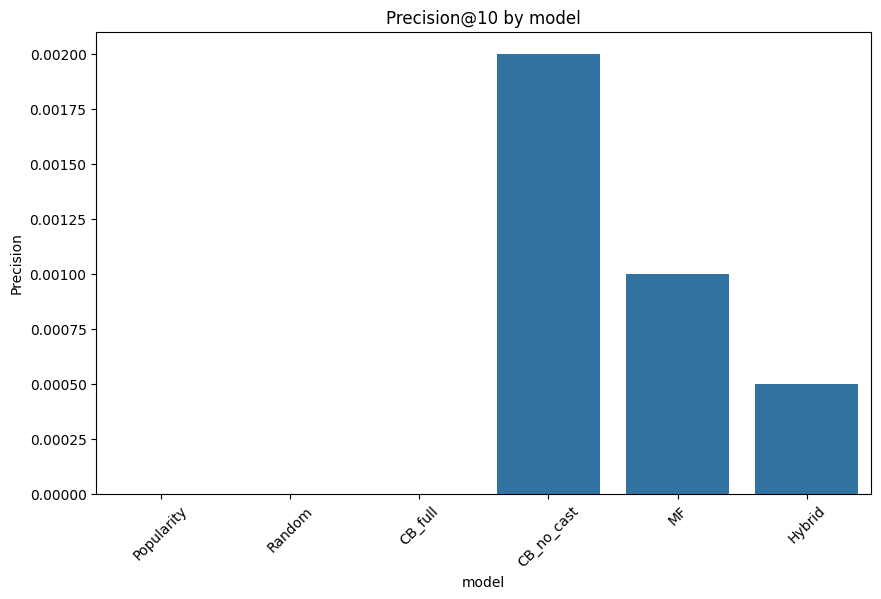

Saved metrics table to evaluation_metrics_table.csv


In [28]:

# 6) Visual summaries
rows = []
for model, info in all_results.items():
    for k in K_LIST:
        s = info['summary'][k]
        rows.append({
            'model': model, 'K': k,
            'Precision': s['precision'], 'Recall': s['recall'], 'HitRate': s['hit'], 'NDCG': s['ndcg'],
            'Coverage': info['coverage'], 'Novelty': info['novelty'], 'ILD': info['ild']
        })
df_metrics = pd.DataFrame(rows)

print("\nMetrics table:")
print(df_metrics.pivot(index='model', columns='K', values='Precision'))

plt.figure(figsize=(10,6))
sns.barplot(data=df_metrics[df_metrics['K']==10], x='model', y='Precision')
plt.title('Precision@10 by model')
plt.xticks(rotation=45)
plt.show()

# Save metrics
df_metrics.to_csv('evaluation_metrics_table.csv', index=False)
print("Saved metrics table to evaluation_metrics_table.csv")


In [29]:
print(all_results.keys())
print(rows[:3])
print(df_metrics.head())

dict_keys(['Popularity', 'Random', 'CB_full', 'CB_no_cast', 'MF', 'Hybrid'])
[{'model': 'Popularity', 'K': 10, 'Precision': 0.0, 'Recall': 0.0, 'HitRate': 0.0, 'NDCG': 0.0, 'Coverage': 0.04058041218953673, 'Novelty': 9.234420188139456, 'ILD': nan}, {'model': 'Popularity', 'K': 20, 'Precision': 0.0, 'Recall': 0.0, 'HitRate': 0.0, 'NDCG': 0.0, 'Coverage': 0.04058041218953673, 'Novelty': 9.234420188139456, 'ILD': nan}, {'model': 'Random', 'K': 10, 'Precision': 0.0, 'Recall': 0.0, 'HitRate': 0.0, 'NDCG': 0.0, 'Coverage': 0.08395719570195526, 'Novelty': 16.34041764687705, 'ILD': nan}]
        model   K  Precision  Recall  HitRate  NDCG  Coverage    Novelty  ILD
0  Popularity  10        0.0     0.0      0.0   0.0  0.040580   9.234420  NaN
1  Popularity  20        0.0     0.0      0.0   0.0  0.040580   9.234420  NaN
2      Random  10        0.0     0.0      0.0   0.0  0.083957  16.340418  NaN
3      Random  20        0.0     0.0      0.0   0.0  0.083957  16.340418  NaN
4     CB_full  10      